# Stock Price Prediction

<b>In this notebook i used EUR/USD hourly basd dataset to predict next hour price using LSTM</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

C:\Users\ebraa\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ebraa\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ebraa\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ebraa\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
data = pd.read_csv('eurusd.csv',index_col='Unnamed: 0')

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
2020-12-31 22:00:00+00:00,1.222195,1.223092,1.222195,1.223092,1.223092,0
2021-01-04 00:00:00+00:00,1.225190,1.225640,1.224440,1.224440,1.224440,0
2021-01-04 01:00:00+00:00,1.224590,1.225941,1.224440,1.225640,1.225640,0
2021-01-04 02:00:00+00:00,1.225640,1.226392,1.225340,1.225941,1.225941,0
2021-01-04 03:00:00+00:00,1.226091,1.226392,1.225340,1.225791,1.225791,0


In [4]:
data = data.drop(['Adj Close', 'Volume'], axis=1)


In [5]:
data.tail(10)

,Open,High,Low,Close
2022-09-14 13:00:00+01:00,0.999400,1.000801,0.998702,1.000100
2022-09-14 14:00:00+01:00,0.999800,1.000901,0.998403,0.999400
2022-09-14 15:00:00+01:00,0.999500,1.000100,0.997307,1.000100
2022-09-14 16:00:00+01:00,1.000100,1.000500,0.999300,0.999600
2022-09-14 17:00:00+01:00,0.999500,1.001202,0.999101,1.000000
2022-09-14 18:00:00+01:00,1.000000,1.000200,0.999001,0.999300
2022-09-14 19:00:00+01:00,0.999001,0.999201,0.998203,0.998203
2022-09-14 20:00:00+01:00,0.998104,0.998303,0.997208,0.998203
2022-09-14 21:00:00+01:00,0.998104,0.998602,0.997904,0.998303
2022-09-14 22:00:00+01:00,0.998203,0.998702,0.997705,0.998303


In [6]:
close = data['Close']

In [7]:
close_1 = pd.DataFrame(data['Close'].reset_index(drop=True))
close_1 = close_1.drop([0])

In [8]:
features = data.drop(['Close'],axis=1)

In [9]:
features = features.drop(['2022-09-14 22:00:00+01:00'])

In [10]:
close_1 = close_1.set_index(features.index)

In [11]:
full_data = pd.concat([features, close_1], axis=1)

In [12]:
full_data

,Open,High,Low,Close
2020-12-31 22:00:00+00:00,1.222195,1.223092,1.222195,1.224440
2021-01-04 00:00:00+00:00,1.225190,1.225640,1.224440,1.225640
2021-01-04 01:00:00+00:00,1.224590,1.225941,1.224440,1.225941
2021-01-04 02:00:00+00:00,1.225640,1.226392,1.225340,1.225791
2021-01-04 03:00:00+00:00,1.226091,1.226392,1.225340,1.225190
...,...,...,...,...
2022-09-14 17:00:00+01:00,0.999500,1.001202,0.999101,0.999300
2022-09-14 18:00:00+01:00,1.000000,1.000200,0.999001,0.998203
2022-09-14 19:00:00+01:00,0.999001,0.999201,0.998203,0.998203
2022-09-14 20:00:00+01:00,0.998104,0.998303,0.997208,0.998303


In [13]:
def lstm_split(data, n_steps):
    x, y = [], []
    for i in range(len(data)-n_steps+1):
        x.append(data[i:i+n_steps, :-1])
        y.append(data[i+n_steps-1,-1])
    return np.array(x), np.array(y)

In [14]:
x1, y1 = lstm_split(full_data.values, 23)

In [15]:
train_split = 0.6
split_idx = int(np.ceil(len(x1)*train_split)) 
data_index = full_data.index
x_train, xx_test = x1[:split_idx], x1[split_idx:]
y_train, yy_test = y1[:split_idx], y1[split_idx:]
x_train_date, xx_test_date = data_index[:split_idx], data_index[split_idx:]

val_split = 0.5
split_idx2 = int(np.ceil(len(xx_test)*val_split)) 

x_test, x_val = xx_test[:split_idx2], xx_test[split_idx2:]
y_test, y_val = yy_test[:split_idx2], yy_test[split_idx2:]
x_test_date, x_val_date = xx_test_date[:split_idx2], xx_test_date[split_idx2:]


In [16]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), activation= 'relu',return_sequences=True))
model.add(LSTM(128, activation= 'relu'))
model.add(Dense(1024, activation= 'relu'))
model.add(Dense(128, activation= 'relu'))
#model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 128)           67584     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 462,593
Trainable params: 462,593
Non-trainable params: 0
_________________________________________________________________


In [18]:
import datetime
chk_path = 'stockNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [19]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=30, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              min_delta=1e-08,
                              min_lr=0.0000001)

In [20]:
history = model.fit(x_train, y_train, epochs = 300, batch_size=23, verbose=1, shuffle=False, 
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, earlystop, reduce_lr])

Train on 6309 samples, validate on 2103 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
6302/6309 [============================>.] - ETA: 0s - loss: 0.1127
Epoch 00001: val_loss improved from inf to 0.00073, saving model to stockNet.h5
6309/6309 [==============================] - 29s 5ms/sample - loss: 0.1126 - val_loss: 7.3404e-04
Epoch 2/300
6302/6309 [============================>.] - ETA: 0s - loss: 1.3704e-05
Epoch 00002: val_loss improved from 0.00073 to 0.00072, saving model to stockNet.h5
6309/6309 [==============================] - 26s 4ms/sample - loss: 1.3692e-05 - val_loss: 7.2118e-04
Epoch 3/300
6302/6309 [============================>.] - ETA: 0s - loss: 1.4505e-05
Epoch 00003: val_loss improved from 0.00072 to 0.00070, saving model to stockNet.h5
6309/6309 [==============================] - 26s 4ms/sample - loss: 1.4496e-05 - val_loss: 6.9514e-04
Epoch 4/300
6302/6309 [============================>.] - ETA

Epoch 30/300
6302/6309 [============================>.] - ETA: 0s - loss: 5.4059e-06- ETA: 0s - loss: 5.
Epoch 00030: val_loss improved from 0.00001 to 0.00001, saving model to stockNet.h5
6309/6309 [==============================] - 26s 4ms/sample - loss: 5.4012e-06 - val_loss: 1.0453e-05
Epoch 31/300
6302/6309 [============================>.] - ETA: 0s - loss: 4.7180e-06
Epoch 00031: val_loss improved from 0.00001 to 0.00001, saving model to stockNet.h5
6309/6309 [==============================] - 27s 4ms/sample - loss: 4.7141e-06 - val_loss: 1.0395e-05
Epoch 32/300
6302/6309 [============================>.] - ETA: 0s - loss: 4.7463e-06
Epoch 00032: val_loss improved from 0.00001 to 0.00001, saving model to stockNet.h5
6309/6309 [==============================] - 26s 4ms/sample - loss: 4.7424e-06 - val_loss: 1.0349e-05
Epoch 33/300
6302/6309 [============================>.] - ETA: 0s - loss: 4.7790e-06
Epoch 00033: val_loss improved from 0.00001 to 0.00001, saving model to stockNet.h

Epoch 62/300
6302/6309 [============================>.] - ETA: 0s - loss: 5.0372e-06
Epoch 00062: val_loss did not improve from 0.00001
6309/6309 [==============================] - 26s 4ms/sample - loss: 5.0338e-06 - val_loss: 1.0358e-05
Epoch 63/300
6302/6309 [============================>.] - ETA: 0s - loss: 5.0347e-06
Epoch 00063: val_loss did not improve from 0.00001
6309/6309 [==============================] - 25s 4ms/sample - loss: 5.0313e-06 - val_loss: 1.0356e-05
Epoch 64/300
6302/6309 [============================>.] - ETA: 0s - loss: 5.0322e-06
Epoch 00064: val_loss did not improve from 0.00001
Restoring model weights from the end of the best epoch.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1e-07.
6309/6309 [==============================] - 26s 4ms/sample - loss: 5.0288e-06 - val_loss: 1.0354e-05
Epoch 00064: early stopping


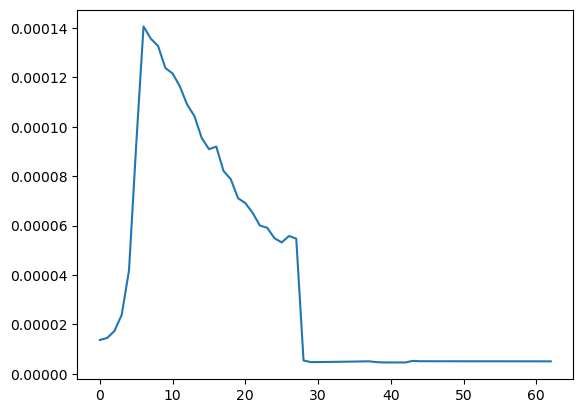

In [21]:
plt.plot(history.history['loss'][1:])

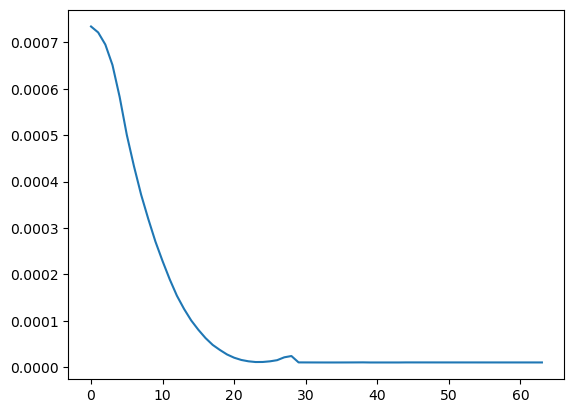

In [22]:
plt.plot(history.history['val_loss'])

In [23]:
y_pred = model.predict(x_test)

In [24]:
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

MAE:  0.002098534371361983
R2:  0.9902928197630623
RMSE:  0.002868261789565143
MAPE:  0.0019037748361313736


In [25]:
close_1

,Close
2020-12-31 22:00:00+00:00,1.224440
2021-01-04 00:00:00+00:00,1.225640
2021-01-04 01:00:00+00:00,1.225941
2021-01-04 02:00:00+00:00,1.225791
2021-01-04 03:00:00+00:00,1.225190
...,...
2022-09-14 17:00:00+01:00,0.999300
2022-09-14 18:00:00+01:00,0.998203
2022-09-14 19:00:00+01:00,0.998203
2022-09-14 20:00:00+01:00,0.998303


In [26]:
cl_current_hour     = pd.Series(y_test[:-1],name='Close@h')
cl_next_hour        = pd.Series(y_test[1:], name='Close@h+1')
predected_next_hour = pd.Series(y_pred.reshape(-1)[1:], name='Predicted_Close@h+1')

In [27]:
f_data = pd.concat([cl_current_hour, cl_next_hour, predected_next_hour], axis=1)

In [28]:
f_data = f_data.set_index(x_test_date[1:])


In [29]:
f_data

,Close@h,Close@h+1,Predicted_Close@h+1
2022-01-10 07:00:00+00:00,1.134301,1.133915,1.133897
2022-01-10 08:00:00+00:00,1.133915,1.134559,1.134030
2022-01-10 09:00:00+00:00,1.134559,1.135203,1.134146
2022-01-10 10:00:00+00:00,1.135203,1.133658,1.134274
2022-01-10 11:00:00+00:00,1.133658,1.133273,1.134404
...,...,...,...
2022-05-12 10:00:00+01:00,1.041992,1.041016,1.038634
2022-05-12 11:00:00+01:00,1.041016,1.037883,1.038815
2022-05-12 12:00:00+01:00,1.037883,1.038961,1.038952
2022-05-12 13:00:00+01:00,1.038961,1.038530,1.038972
